## Import necessary modules and check GPU devices

In [1]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms as T
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
%pwd

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/yw5281/code/Users/yw528/CV_Project1'

In [3]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

torch:  1.10 ; cuda:  cu102
device:  cuda:0


## Hyperparameters

In [4]:
LR = 0.001
BATCH_SIZE = 10
GAMMA = 0.2
NUM_EPOCH = 10

## Pre-processing

### Load and transform the dataset

In [5]:
# Define the transforms to be applied to the images

# Reference: https://github.com/AIPI540/AIPI540-Deep-Learning-Applications/blob/main/2_computer_vision/CNNs/transfer_learning.ipynb

transform_train = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=30),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

transform_val_test = T.Compose([
    T.Resize(256), 
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)), # normalize the pixel values according to the mean and std of ImageNet
])

# Apply the training transform to the training set and load the training set 
data_dir = 'data/final_output_data'
dataset_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Apply the validation & test transform to the validation set and load the validation set 
dataset_val = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform_val_test)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Apply the validation & test transform to the test set and load the test set 
dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform_val_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True, num_workers=4)

dataloaders = {'train': dataloader_train, 
               'val': dataloader_val, 
               'test': dataloader_test}
dataset_sizes = {'train': len(dataset_train), 
                 'val': len(dataset_val), 
                 'test': len(dataset_test)}
print(dataset_sizes)
class_names = dataset_train.classes

{'train': 886, 'val': 382, 'test': 103}


### Visualization 

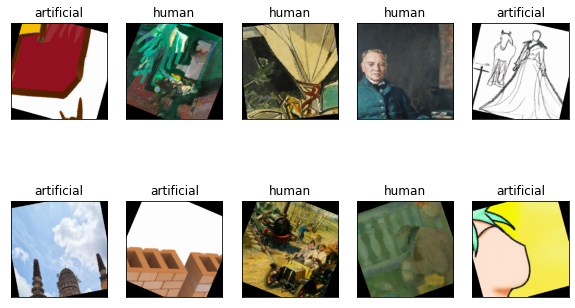

In [6]:
images, labels = next(iter(dataloader_train))
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(2, BATCH_SIZE//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

## Modeling & Evaluation

### Define model architecture

In [7]:
# Instantiate pre-trained resnet
model = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model.parameters():
    param.requires_grad = False

In [8]:
# Get the number of inputs to final Linear layer
num_features = model.fc.in_features

# Replace final Linear layer with a new Linear with the same number of inputs but just 2 outputs (2 classes)
model.fc = nn.Linear(num_features, 2)

In [9]:
# Summary of the model (after modification)
summary(model, (images.shape[1:]),batch_size=BATCH_SIZE, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [10, 64, 112, 112]           9,408
       BatchNorm2d-2         [10, 64, 112, 112]             128
              ReLU-3         [10, 64, 112, 112]               0
         MaxPool2d-4           [10, 64, 56, 56]               0
            Conv2d-5           [10, 64, 56, 56]          36,864
       BatchNorm2d-6           [10, 64, 56, 56]             128
              ReLU-7           [10, 64, 56, 56]               0
            Conv2d-8           [10, 64, 56, 56]          36,864
       BatchNorm2d-9           [10, 64, 56, 56]             128
             ReLU-10           [10, 64, 56, 56]               0
       BasicBlock-11           [10, 64, 56, 56]               0
           Conv2d-12           [10, 64, 56, 56]          36,864
      BatchNorm2d-13           [10, 64, 56, 56]             128
             ReLU-14           [10, 64,

### Define cost function and optimizer

In [10]:
# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=LR)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=GAMMA)

### Training & Evaluation

In [11]:
# function for model training & evaluation
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs, defrost):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    # "defrost" all the model parameters by turning on autograd for all layers so the layer weights are also trained
    if defrost: 
        print("unfreeze the model and start training again:" )
        for param in model.parameters():
            param.requires_grad = True

        since = time.time()
        num_epochs_unfreeze = 5 # defrost parameter training with 5 epochs
        for epoch in range(1, num_epochs_unfreeze+1): 
            print('Epoch {}/{}'.format(epoch, num_epochs_unfreeze))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Get the input images and labels, and send to GPU if available
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the weight gradients
                    optimizer.zero_grad()

                    # Forward pass to get outputs and calculate loss
                    # Track gradient only for training data
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backpropagation to get the gradients with respect to each weight
                        # Only if in train
                        if phase == 'train':
                            loss.backward()
                            # Update the weights
                            optimizer.step()

                    # Convert loss into a scalar and add it to running_loss
                    running_loss += loss.item() * inputs.size(0)
                    # Track number of correct predictions
                    running_corrects += torch.sum(preds == labels.data)

                # Step along learning rate scheduler when in train
                if phase == 'train':
                    scheduler.step()

                # Calculate and display average loss and accuracy for the epoch
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # If model performs better on val set, save weights as the best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:3f}'.format(best_acc))

        # Load the weights from best model
        model.load_state_dict(best_model_wts)

    return model

In [12]:
# Train and save the model
model = train_model(model, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=NUM_EPOCH, defrost=True)
torch.save(model.state_dict(), "models/model4.pth")

Epoch 1/10
----------
train Loss: 0.4699 Acc: 0.7901
val Loss: 0.2454 Acc: 0.9005

Epoch 2/10
----------
train Loss: 0.3154 Acc: 0.8623
val Loss: 0.2429 Acc: 0.9084

Epoch 3/10
----------
train Loss: 0.2358 Acc: 0.9142
val Loss: 0.1781 Acc: 0.9346

Epoch 4/10
----------
train Loss: 0.2772 Acc: 0.8905
val Loss: 0.1514 Acc: 0.9424

Epoch 5/10
----------
train Loss: 0.2505 Acc: 0.8962
val Loss: 0.1736 Acc: 0.9424

Epoch 6/10
----------
train Loss: 0.2563 Acc: 0.8973
val Loss: 0.3536 Acc: 0.8586

Epoch 7/10
----------
train Loss: 0.2493 Acc: 0.8871
val Loss: 0.1317 Acc: 0.9503

Epoch 8/10
----------
train Loss: 0.1885 Acc: 0.9199
val Loss: 0.1428 Acc: 0.9476

Epoch 9/10
----------
train Loss: 0.1755 Acc: 0.9255
val Loss: 0.1342 Acc: 0.9503

Epoch 10/10
----------
train Loss: 0.1795 Acc: 0.9334
val Loss: 0.1323 Acc: 0.9503

Training complete in 6m 10s
Best val Acc: 0.950262
unfreeze the model and start training again:
Epoch 1/5
----------
train Loss: 0.3976 Acc: 0.8758
val Loss: 0.8556 Acc:

### Test

In [13]:
# load the existing model checkpoints
model.load_state_dict(torch.load("models/model4.pth"))

<All keys matched successfully>

In [14]:
model = model.to(device) # Send model to GPU if available
with torch.no_grad():
    model.eval()
    # Get all test images (every image in one batch)
    images, labels = next(iter(dataloader_test))
    images, labels = images.to(device), labels.to(device)
    # Get predictions
    _,preds = torch.max(model(images), 1)
    # convert predictions & labels to numpy array format
    y_pred = np.squeeze(preds.cpu().numpy())
    y_true = np.squeeze(labels.cpu().numpy())

In [15]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  artificial       0.65      1.00      0.79        51
       human       1.00      0.48      0.65        52

    accuracy                           0.74       103
   macro avg       0.83      0.74      0.72       103
weighted avg       0.83      0.74      0.72       103



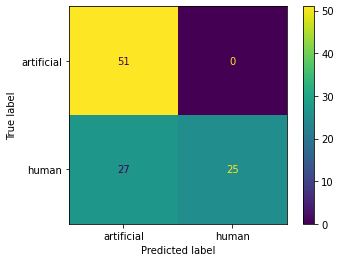

In [16]:
conf_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

### Visualization

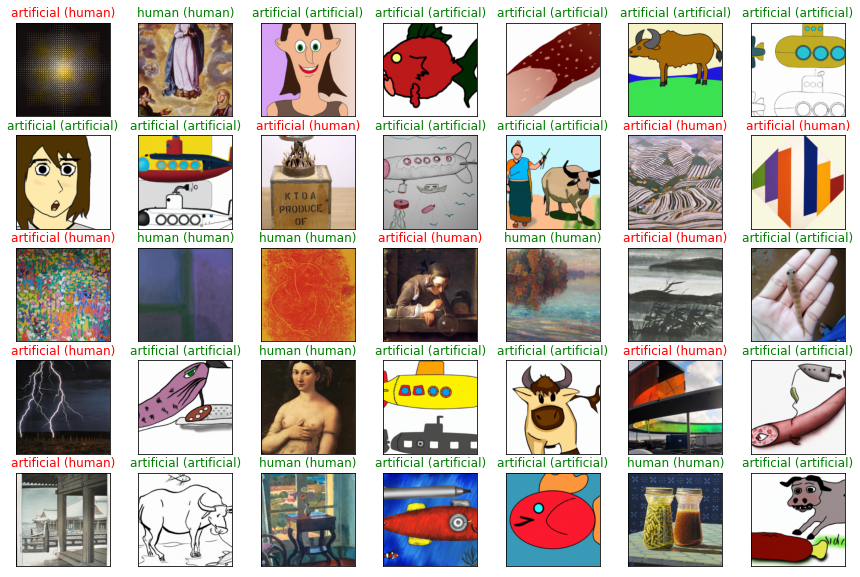

In [17]:
def visualize_results(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(5, len(preds)//5, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

dataloader_test_visual = torch.utils.data.DataLoader(dataset_test, batch_size=35, shuffle=True, num_workers=4)
visualize_results(model, dataloader_test_visual, device)